# Exploratory Data Analysis

In [345]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# display multiple outputs, default is 'last_expr' (last expression)
# http://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [249]:
data_dir = './data/extracted/'
out_dir = './output/'

In [3]:
df_reg_compact = pd.read_csv(data_dir + "RegularSeasonCompactResults.csv")
df_reg = pd.read_csv(data_dir + "RegularSeasonDetailedResults.csv")

In [325]:
df_tourney = pd.read_csv(data_dir + "NCAATourneyCompactResults.csv")
df_tourney.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
dtype: object

In [5]:
df_reg_compact.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
dtype: object

## Feature Ideas
- Team's toughness of schedule. The concept here is that all these teams have made it to the tourney, so the tougher their schedule was to get to the tourney, the better the team.
- Use unsupervised learning to form a cluster for each team that is in the tournament. For example, find the 10 best teams that are "most like each team" (tbd). The teams do not have to be distinct -- that is, if USC is one of the teams for ASU, it can also be one of the teams for UCLA. See if there is a matchup outcome between clusters of teams.
- Use unsupervised learning to group each team into a distnct bucket. Use per bucket standings as a feature.
- Geographic distance of teams to venue
- See what the MO of a certain team is. Check historical games and see if they won from that MO or some other means. Could this indicate "flukey" wins? Or conversely, would this indicate the versatility of a team?
- How can we use the quality of individual players as predictors? Do we roll them up to a team level?
    - Maybe we create tiers of players and see how many players of each tier are on a team
    - Maybe use the max of player quality
- Let's say we take something like team rank as classes and try and predict rank based on game level features throughout the year. So what features make a team ranked 1, versus 2, versus 3... Then can we predict the rank of teams, and somehow use that predicted rank in the team level model? So for example, each row is every play (or game) by USC and the target for each of those is the overall rank at the end of the season. Can we use play (or game) features to predict rank?

### Contingent Results Idea

Let's predict outcome past of regular season games. For this prediction, we use the actual outcome of that game as priors and weight this prior pretty heavily. Then, we create a model with a bunch of other features. E.g. does it make a difference that the game was home versus away? Were there "flukey" plays. Were there injured key players? Was there a coaching / staffing change?

Using these factors, we try and predict which team wins. That is, we're assuming the actual outcome is the best estimate, but we take into considerations that could have skewed the win. When we have predicted scores, tally up season winpct on predicted scores and model tournament outcomes with the predicted winpcts.

### Convert Regular Season Win/Lose to Continuous

Use weekly opponent difficulty to so that rather than a binary win/lose variable, we use some continous value between 1 and 0. This essentially weights wins and losses so that not all wins and losses are the same. Then use these numbers at the aggregate to find a "winpct" that is a weighted average of these numbers. 


## Win Percentage

Let's start with something really basic. Use the win percentage of prediction years regular season of both teams. I expect positive weights for win pct and negative weights for opposing team's win pct.

In [90]:
categorical = ['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc']
continuous = ['WScore', 'LScore', 'NumOT']

df_reg_compact[categorical] = df_reg_compact[categorical].astype(str)

In [103]:
wins = df_reg_compact[['Season', 'WTeamID', 'DayNum']].groupby(by=['Season', 'WTeamID']).size().reset_index()
losses = df_reg_compact[['Season', 'LTeamID', 'DayNum']].groupby(by=['Season', 'LTeamID']).size().reset_index()

In [184]:
wins = df_reg_compact[['Season', 'WTeamID', 'DayNum']].groupby(by=['Season', 'WTeamID']).count()
wins = wins.reset_index()
wins = wins.rename(columns={'WTeamID': 'TeamID', 'DayNum': 'Wins'})

losses = df_reg_compact[['Season', 'LTeamID', 'DayNum']].groupby(by=['Season', 'LTeamID']).count()
losses = losses.reset_index()
losses = losses.rename(columns={'LTeamID': 'TeamID', 'DayNum': 'Losses'})

winpct = pd.merge(wins, losses, how='outer', on=['Season', 'TeamID'])
winpct['Wins'].fillna(0, inplace=True)
winpct['Losses'].fillna(0, inplace=True)
winpct['winpct'] = winpct['Wins'] / (winpct['Wins'] + winpct['Losses'])

# winpct_data.set_index(['Season', 'TeamID'])
# Retrieve from this table to retrieve featuers for modeling

winpct.head()

,Season,TeamID,Wins,Losses,winpct
0,1985,1102,5.0,19.0,0.208333
1,1985,1103,9.0,14.0,0.391304
2,1985,1104,21.0,9.0,0.700000
3,1985,1106,10.0,14.0,0.416667
4,1985,1108,19.0,6.0,0.760000


It's important that we correctly fill zeros. Because of the way that the season data was structured, certain teams may never be listed in the WTeamID or LTeamID column if they were either undefeated or winless. Because of this, doing a full outer join causes missing values for these rare occurences. Wins and Losses need to be imputed with zero value, prior to calculating win percentage to make sure we get the correct win percentage.

In [326]:
df_tourney[categorical] = df_tourney[categorical].astype(str)
tourney_results = df_tourney[['Season', 'WTeamID', 'LTeamID']]

Wpct = winpct[['Season', 'TeamID', 'winpct']].rename(columns={'TeamID': 'WTeamID', 'winpct': 'Wwinpct'})
Lpct = winpct[['Season', 'TeamID', 'winpct']].rename(columns={'TeamID': 'LTeamID', 'winpct': 'Lwinpct'})

tourney_winpct = pd.merge(tourney_results, Wpct, 
                          how='left', on=['Season', 'WTeamID'])
tourney_winpct = pd.merge(tourney_winpct, Lpct, 
                          how='left', on=['Season', 'LTeamID'])

# vertical stack with targets
tmp1 = tourney_winpct[['Season', 'WTeamID', 'Wwinpct', 'Lwinpct']].\
rename(columns={'WTeamID': 'TeamID', 'Wwinpct': 'winpct', 'Lwinpct': 'opp_winpct'})
tmp1['outcome'] = 1

tmp2 = tourney_winpct[['Season', 'LTeamID', 'Lwinpct', 'Wwinpct']].\
rename(columns={'LTeamID': 'TeamID', 'Lwinpct': 'winpct', 'Wwinpct': 'opp_winpct'})
tmp2['outcome'] = 0

train_winpct = pd.concat((tmp1, tmp2))
features = ['winpct', 'opp_winpct']
target = ['outcome']
train_winpct.head()
train_winpct.shape

,Season,TeamID,winpct,opp_winpct,outcome
0,1985,1116,0.636364,0.666667,1
1,1985,1120,0.620690,0.680000,1
2,1985,1207,0.925926,0.379310,1
3,1985,1229,0.740741,0.678571,1
4,1985,1242,0.766667,0.740741,1


(4234, 5)

In [203]:
from sklearn.linear_model import LogisticRegression

features = ['winpct', 'opp_winpct']
target = ['outcome']

lr = LogisticRegression()
lr.fit(train_winpct[features], train_winpct[target].values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Do we get the same results if instead of winpct and opp_winpct, we use a winpct differential?

In [366]:
train_winpct['winpctDiff'] = train_winpct['winpct'] - train_winpct['opp_winpct']

In [262]:
features = ['winpctDiff']
target = ['outcome']

lr2 = LogisticRegression()
lr2.fit(train_winpct[features], train_winpct[target].values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [264]:
lr2.coef_
lr.coef_

array([[ 4.79406786]])

array([[ 4.54506683, -4.54506684]])

In [265]:
def get_winpct(Season, TeamID):
    return winpct[(winpct['Season'] == Season) & (winpct['TeamID'] == TeamID)].winpct.values[0]

# test
get_winpct('2014', '1110')

0.625

In [232]:
submission = pd.read_csv(data_dir + "SampleSubmissionStage1.csv")
submission.drop(['Pred'], axis=1, inplace=True)
submission['Season'] = submission['ID'].apply(lambda x: x.split('_')[0])
submission['Team1'] = submission['ID'].apply(lambda x: x.split('_')[1])
submission['Team2'] = submission['ID'].apply(lambda x: x.split('_')[2])
submission['Team1_winpct'] = submission[['Season', 'Team1']]\
.apply(lambda row: get_winpct(row['Season'], row['Team1']), axis=1)
submission['Team2_winpct'] = submission[['Season', 'Team2']]\
.apply(lambda row: get_winpct(row['Season'], row['Team2']), axis=1)

submission.head()

,ID,Season,Team1,Team2,Team1_winpct
0,2014_1107_1110,2014,1107,1110,0.5625
1,2014_1107_1112,2014,1107,1112,0.5625
2,2014_1107_1113,2014,1107,1113,0.5625
3,2014_1107_1124,2014,1107,1124,0.5625
4,2014_1107_1140,2014,1107,1140,0.5625


In [332]:
submission.head()
submission.shape

,ID,Season,Team1,Team2,Team1_winpct,Team2_winpct,winpctDiff
0,2014_1107_1110,2014,1107,1110,0.5625,0.625000,-0.062500
1,2014_1107_1112,2014,1107,1112,0.5625,0.882353,-0.319853
2,2014_1107_1113,2014,1107,1113,0.5625,0.656250,-0.093750
3,2014_1107_1124,2014,1107,1124,0.5625,0.666667,-0.104167
4,2014_1107_1140,2014,1107,1140,0.5625,0.666667,-0.104167


(9112, 7)

v01 Submission
- Regular Season Win Percentage
- Opponent Regular Season Win Percentage

In [269]:
features = ['Team1_winpct', 'Team2_winpct']
predictions = lr.predict_proba(submission[features])[:, 1]
predictions

df_pred = pd.DataFrame(predictions, columns=['Pred'])
df_pred['ID'] = submission['ID'].copy()
df_pred = df_pred[['ID', 'Pred']]

df_pred.head()
df_pred.to_csv(out_dir + 'v01.csv', index=False)

array([ 0.42945705,  0.18942464,  0.39505799, ...,  0.57299776,
        0.69610247,  0.63058184])

,ID,Pred
0,2014_1107_1110,0.429457
1,2014_1107_1112,0.189425
2,2014_1107_1113,0.395058
3,2014_1107_1124,0.383801
4,2014_1107_1140,0.383801


v02 Submission
- Regular Season Win Percentage Differential

In [284]:
submission['winpctDiff'] = submission['Team1_winpct'] - submission['Team2_winpct']
predictions = lr2.predict_proba(submission['winpctDiff'].values.reshape(-1, 1))[:,1]
predictions

df_pred = pd.DataFrame(predictions, columns=['Pred'])
df_pred['ID'] = submission['ID'].copy()
df_pred = df_pred[['ID', 'Pred']]

df_pred.head()
df_pred.to_csv(out_dir + 'v02.csv', index=False)

array([ 0.42564812,  0.17749725,  0.389493  , ...,  0.57693515,
        0.70562145,  0.6373794 ])

,ID,Pred
0,2014_1107_1110,0.425648
1,2014_1107_1112,0.177497
2,2014_1107_1113,0.389493
3,2014_1107_1124,0.377686
4,2014_1107_1140,0.377686


In [338]:
predict_class = lr2.predict(submission['winpctDiff'].values.reshape(-1, 1))
predict_class[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [340]:
sub_predict = submission[['Season', 'Team1', 'Team2']].copy()
sub_predict['prediction'] = predict_class
sub_predict.head(10)
sub_predict.shape

,Season,Team1,Team2,prediction
0,2014,1107,1110,0
1,2014,1107,1112,0
2,2014,1107,1113,0
3,2014,1107,1124,0
4,2014,1107,1140,0
5,2014,1107,1142,1
6,2014,1107,1153,0
7,2014,1107,1157,0
8,2014,1107,1160,0
9,2014,1107,1163,0


(9112, 4)

## Naive Bayes

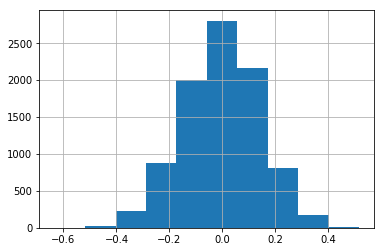

In [359]:
submission['winpctDiff'].hist()

In [375]:
from sklearn.naive_bayes import GaussianNB

features = ['winpctDiff']
target = ['outcome']

nb = GaussianNB()
nb.fit(train_winpct[features], train_winpct[target].values.ravel())
predictions = nb.predict_proba(submission['winpctDiff'].values.reshape(-1, 1))[:,1]

GaussianNB(priors=None)

v03 Submission
- Simple Gaussian Naive Bayes

In [376]:
df_pred = pd.DataFrame(predictions, columns=['Pred'])
df_pred['ID'] = submission['ID'].copy()
df_pred = df_pred[['ID', 'Pred']]

df_pred.head()
df_pred.to_csv(out_dir + 'v03.csv', index=False)

,ID,Pred
0,2014_1107_1110,0.422610
1,2014_1107_1112,0.168393
2,2014_1107_1113,0.385065
3,2014_1107_1124,0.372825
4,2014_1107_1140,0.372825


## Prediction and Model Evaluation

One interesting thing to note is that Kaggle only evaluates on a small subset of our predictions -- the subset that actually occurs. We submit prediction probabilities for all possible combinations, and Kaggle evaluates the games that actually occurred.

Test Data: 2014 - 2017 Tournament Outcomes

I base test data on tourney outcomes from 2014 - 2017. I'll use this to evaluate model accuracy first. Only then will I make prediction probabilities for the rest of the games in 2014 - 2017. Doing it the other way around doesn't do anything, since I can only measure model accuracy based on the games that actually occurred. 

To avoid overfitting, data from 2014 - 2017 tournament should be held out with the exception of:
- 2014 - 2017 Tournament Seeds
- 2014 - 2017 Pre-Tournament Rankings
- 2014 - 2017 Tournament Slots

Note that 2014 - 2017 regular season data is ok to use, since this will also be available for 2018 predictions (Stage 2).


In [329]:
# tourney outcome
df_tourney['outcome'] = np.where(df_tourney['WTeamID'] < df_tourney['LTeamID'], 1, 0)
df_tourney['Team1'] = np.where(df_tourney['outcome'] == 1, df_tourney['WTeamID'], df_tourney['LTeamID'])
df_tourney['Team2'] = np.where(df_tourney['outcome'] == 1, df_tourney['LTeamID'], df_tourney['WTeamID'])


In [341]:
df_tourney[df_tourney['Season'] == '2014'].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,outcome,Team1,Team2
1849,2014,134,1107,71,1291,64,N,0,1,1107,1291
1850,2014,134,1301,74,1462,59,N,0,1,1301,1462
1851,2014,135,1142,81,1411,69,N,0,1,1142,1411
1852,2014,135,1397,78,1234,65,N,1,0,1234,1397
1853,2014,136,1163,89,1386,81,N,1,1,1163,1386


In [351]:
df_acc = pd.merge(df_tourney, sub_predict, how='inner', on=['Season', 'Team1', 'Team2'])
df_acc.head()
df_acc[df_acc['Season'] == '2014'].shape
print(classification_report(df_acc['outcome'].values, df_acc['prediction'].values))

conf = confusion_matrix(df_acc['outcome'].values, df_acc['prediction'].values)
conf = pd.DataFrame(data=conf)
conf.columns.name = 'Predicted label'
conf.index.name = 'Actual label'

conf

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,outcome,Team1,Team2,prediction
0,2014,134,1107,71,1291,64,N,0,1,1107,1291,1
1,2014,134,1301,74,1462,59,N,0,1,1301,1462,0
2,2014,135,1142,81,1411,69,N,0,1,1142,1411,0
3,2014,135,1397,78,1234,65,N,1,0,1234,1397,1
4,2014,136,1163,89,1386,81,N,1,1,1163,1386,1


(67, 12)

             precision    recall  f1-score   support

          0       0.63      0.56      0.59       137
          1       0.59      0.66      0.62       131

avg / total       0.61      0.61      0.61       268



Predicted label,0,1
Actual label,,
0,77,60
1,45,86


In [146]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

# # train / test split is separated manually here
# # 2014 - 2017 is test data
# train_winpct = winpct_data[winpct_data['Season'].astype(int) < 2014]
# test_winpct = winpct_data[winpct_data['Season'].astype(int) >= 2014]

# lr = LogisticRegression()
# lr.fit(train_winpct[features], train_winpct[target].values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Would changing this to use a differential between winpct yield identical results to having a a feature each for winpct and opponents winpct?

Features at add:
- It's ok to add 2014 through 2017 into the training data for the model... why? Because the "test" data are the matchups for the tournament in 2014 thorugh 2017 -- not the regular season matchups